# 📘 信用卡流失預測模型 - v1_baseline (XGBoost)

## 🔧 Notebook 簡介
本 Notebook 是我們的 baseline (只做get_dummies)模型，用來預測信用卡客戶是否會流失（`Attrition_Flag = 1`）。

---

## 🛠️ 前處理流程

- 🔢 使用 `pd.get_dummies()` 對以下類別欄位做 one-hot encoding：
  - `'Gender'`, `'Education_Level'`, `'Marital_Status'`, `'Income_Category'`, `'Card_Category'`
- ❌ 未進行缺失值填補或 Unknown 處理
- 🏷️ 將 `Attrition_Flag` 轉為 0（Existing Customer）與 1（Attrited Customer）

---

## 🤖 模型設定（XGBClassifier）

- `objective='binary:logistic'`：二元分類任務
- `eval_metric='logloss'`
- `max_depth=4`：防止過擬合
- `learning_rate=0.1`
- `n_estimators=100`
- `scale_pos_weight = 負類數量 / 正類數量`：處理類別不平衡
- 使用 `.fit(X_train, y_train)` 進行訓練

---

## 📈 模型表現（測試集）

| 指標               | 結果     |
|--------------------|----------|
| Accuracy           | 0.96     |
| Recall（流失客戶）| 0.96     |
| Precision（流失）  | 0.82     |
| F1-score（流失）   | 0.88     |
| ROC AUC            | 0.9918    |

Confusion Matrix:
[[1632   69]
 [  13  312]]

---

## 📊 特徵重要性分析

- 🔹 預設 importance（split 次數） Top 3 : `Total_Trans_Amt`, `Total_Trans_Ct`, `Total_Amt_Chng_Q4_Q1`
- 🔸 Gain-based importance（資訊貢獻） Top 3：`Total_Trans_Ct`, `Total_Revolving_Bal`, `Total_Relationship_Count`
- 🆕 Education_Level_Unknown 進入 Gain 排名前 10，代表其資訊價值不低
-  ❗ 某些變數如 CLIENTNUM 雖然排名高，但無實質意義，後續可排除

---

## 🧠 SHAP 模型解釋（單一樣本）

- `Total_Trans_Ct` 為主要降低流失機率的變數（顯著負貢獻）
- `Total_Trans_Amt`、`Total_Revolving_Bal` 為降低風險的重要參數
- `Months_Inactive_12_mon` 仍為顯著提高流失風險的正向變數

---

## 🔚 小結與後續建議

- ✅ 本版本為乾淨的 baseline 模型，模型整體效能穩定，AUC 高達 **0.9918**，recall 達 **96%**，可作為日後改良的比較基準

- 🔁 後續版本可探索：
  - 將 `Unknown` 類別轉為二元 flag 與其他型態比較
  - 使用 `OrdinalEncoding` 處理具順序欄位（如 `Income_Category`）
  - 導入欠採樣、SMOTE 或 `GridSearchCV` 做調參優化


## 一、匯入資料
查看資料

In [2]:
import pandas as pd

# 讀取訓練與測試資料
train_df = pd.read_csv("../data/bank_train.csv")
test_df = pd.read_csv("../data/bank_test.csv")

# 檢查資料大小
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# 顯示前 5 筆資料
display(train_df.head())
display(test_df.head())


Train shape: (8101, 21)
Test shape: (2026, 21)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,806407308,54,F,3,College,Single,Unknown,Blue,49,6,...,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000,Attrited Customer
1,801786483,51,M,0,High School,Single,$80K - $120K,Blue,45,3,...,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236,Existing Customer
2,779870883,45,F,4,High School,Single,$40K - $60K,Blue,29,3,...,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388,Existing Customer
3,720336708,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,5,...,2,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450,Existing Customer
4,716769783,48,F,2,Graduate,Married,Unknown,Blue,40,3,...,4,5104.0,736,4368.0,0.679,3943,78,0.696,0.144,Existing Customer


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,720943308,47,M,3,Graduate,Single,$60K - $80K,Silver,36,1,...,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065,Existing Customer
1,710879283,51,M,1,High School,Married,Less than $40K,Blue,41,3,...,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000,Existing Customer
2,787800108,55,M,2,College,Married,$80K - $120K,Blue,45,5,...,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830,Existing Customer
3,789200208,40,F,4,Uneducated,Married,Unknown,Blue,29,2,...,3,3326.0,2181,1145.0,0.827,13583,110,0.746,0.656,Existing Customer
4,711332883,62,M,1,High School,Single,$60K - $80K,Blue,46,2,...,3,7547.0,2477,5070.0,1.021,5294,73,0.698,0.328,Attrited Customer


In [3]:
# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
pd.set_option('display.max_rows', 100)

# 逐欄位輸出 unique 與 value_counts 統計
for col in categorical_cols:
    print(f"\n🔸 {col}:")
    print("Unique values:", train_df[col].unique())
    display(train_df[col].value_counts())





🔸 Gender:
Unique values: ['F' 'M']


Gender
F    4262
M    3839
Name: count, dtype: int64


🔸 Education_Level:
Unique values: ['College' 'High School' 'Doctorate' 'Graduate' 'Unknown' 'Uneducated'
 'Post-Graduate']


Education_Level
Graduate         2442
High School      1603
Unknown          1232
Uneducated       1219
College           829
Post-Graduate     404
Doctorate         372
Name: count, dtype: int64


🔸 Marital_Status:
Unique values: ['Single' 'Married' 'Divorced' 'Unknown']


Marital_Status
Married     3755
Single      3156
Unknown      599
Divorced     591
Name: count, dtype: int64


🔸 Income_Category:
Unique values: ['Unknown' '$80K - $120K' '$40K - $60K' 'Less than $40K' '$120K +'
 '$60K - $80K']


Income_Category
Less than $40K    2838
$40K - $60K       1442
$80K - $120K      1244
$60K - $80K       1104
Unknown            873
$120K +            600
Name: count, dtype: int64


🔸 Card_Category:
Unique values: ['Blue' 'Silver' 'Gold' 'Platinum']


Card_Category
Blue        7541
Silver       455
Gold          91
Platinum      14
Name: count, dtype: int64

## 二、 資料處理
把所有資料做Get dummy

In [4]:
#針對TRAIN的每一個COLUMN做GET DUMMY
import pandas as pd

# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# 建立 one-hot 編碼的新欄位
train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# 查看結果
print("📌 原始欄位數：", train_df.shape[1])
print("📌 One-hot 後欄位數：", train_df_encoded.shape[1])
train_df_encoded.head()


📌 原始欄位數： 21
📌 One-hot 後欄位數： 39


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,806407308,54,3,49,6,2,3,13184.0,0,13184.0,...,False,False,False,False,False,True,True,False,False,False
1,801786483,51,0,45,3,2,3,10648.0,2517,8131.0,...,False,False,False,True,False,False,True,False,False,False
2,779870883,45,4,29,3,2,1,4595.0,1781,2814.0,...,False,True,False,False,False,False,True,False,False,False
3,720336708,53,3,35,5,3,2,3789.0,1706,2083.0,...,False,True,False,False,False,False,True,False,False,False
4,716769783,48,2,40,3,2,4,5104.0,736,4368.0,...,False,False,False,False,False,True,True,False,False,False


In [5]:
# 將 Attrition_Flag 轉為數值類別
train_df_encoded['Attrition_Flag'] = train_df_encoded['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})

In [6]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       8101 non-null   int64  
 1   Customer_Age                    8101 non-null   int64  
 2   Dependent_count                 8101 non-null   int64  
 3   Months_on_book                  8101 non-null   int64  
 4   Total_Relationship_Count        8101 non-null   int64  
 5   Months_Inactive_12_mon          8101 non-null   int64  
 6   Contacts_Count_12_mon           8101 non-null   int64  
 7   Credit_Limit                    8101 non-null   float64
 8   Total_Revolving_Bal             8101 non-null   int64  
 9   Avg_Open_To_Buy                 8101 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            8101 non-null   float64
 11  Total_Trans_Amt                 8101 non-null   int64  
 12  Total_Trans_Ct                  81

In [7]:
#針對TEST的每一個COLUMN做GET DUMMY
import pandas as pd

# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# 建立 one-hot 編碼的新欄位
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# 查看結果
print("📌 原始欄位數：", test_df.shape[1])
print("📌 One-hot 後欄位數：", test_df_encoded.shape[1])
test_df_encoded.head()


📌 原始欄位數： 21
📌 One-hot 後欄位數： 39


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,720943308,47,3,36,1,1,2,30498.0,1990,28508.0,...,False,False,True,False,False,False,False,False,False,True
1,710879283,51,1,41,3,4,3,1438.3,0,1438.3,...,False,False,False,False,True,False,True,False,False,False
2,787800108,55,2,45,5,1,2,2929.0,2431,498.0,...,False,False,False,True,False,False,True,False,False,False
3,789200208,40,4,29,2,3,3,3326.0,2181,1145.0,...,False,False,False,False,False,True,True,False,False,False
4,711332883,62,1,46,2,3,3,7547.0,2477,5070.0,...,False,False,True,False,False,False,True,False,False,False


In [8]:
# 將 Attrition_Flag 轉為數值類別
test_df_encoded['Attrition_Flag'] = test_df_encoded['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})


In [9]:
test_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       2026 non-null   int64  
 1   Customer_Age                    2026 non-null   int64  
 2   Dependent_count                 2026 non-null   int64  
 3   Months_on_book                  2026 non-null   int64  
 4   Total_Relationship_Count        2026 non-null   int64  
 5   Months_Inactive_12_mon          2026 non-null   int64  
 6   Contacts_Count_12_mon           2026 non-null   int64  
 7   Credit_Limit                    2026 non-null   float64
 8   Total_Revolving_Bal             2026 non-null   int64  
 9   Avg_Open_To_Buy                 2026 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            2026 non-null   float64
 11  Total_Trans_Amt                 2026 non-null   int64  
 12  Total_Trans_Ct                  20

## 三、訓練模型
XGBOOST

In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [11]:
# 拆出特徵與標籤
X_train = train_df_encoded.drop(columns=['Attrition_Flag'])
y_train = train_df_encoded['Attrition_Flag']

X_test = test_df_encoded.drop(columns=['Attrition_Flag'])
y_test = test_df_encoded['Attrition_Flag']


In [12]:
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 二分類任務
    eval_metric='logloss',
    use_label_encoder=False,      # 新版需關掉預設label encoder => 我們自己提供已經數值化的 y，不需要它幫我們 encode
    max_depth=4, #每棵決策樹最多只能分裂到第 4 層
    learning_rate=0.1,
    n_estimators=100, #要建 100 棵弱模型（樹）
    # XGBoost 在計算 gradient 時，會幫「正類別」加大權重，讓模型對正類別（流失客戶）更敏感！ 簡單來說就是幫少的那邊乘上一定的倍數(流失的顧客)
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # 處理不平衡類別
    random_state=42
)

model.fit(X_train, y_train)


c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:26:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## 四、模型評估

In [13]:
# 預測結果
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 機率值（用於 AUC）

# 評估指標
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔍 ROC AUC Score:", roc_auc_score(y_test, y_prob))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1701
           1       0.82      0.96      0.88       325

    accuracy                           0.96      2026
   macro avg       0.91      0.96      0.93      2026
weighted avg       0.96      0.96      0.96      2026

📈 Confusion Matrix:
[[1632   69]
 [  13  312]]
🔍 ROC AUC Score: 0.9918455207344095


## 五、特徵解釋與 SHAP 分析

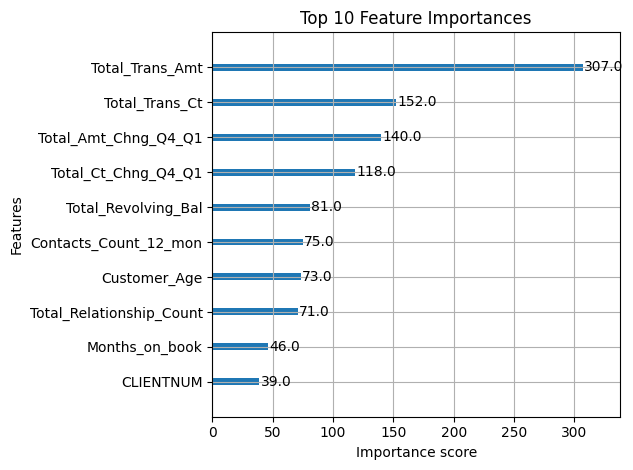

In [14]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


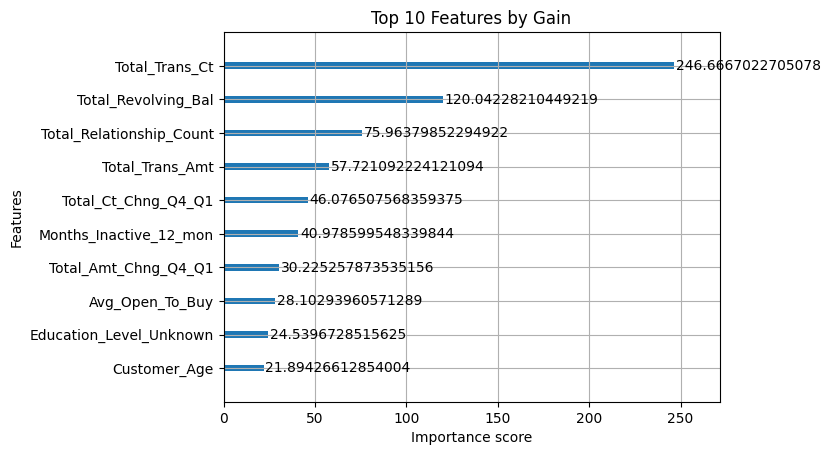

In [15]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Features by Gain")
plt.show()


c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


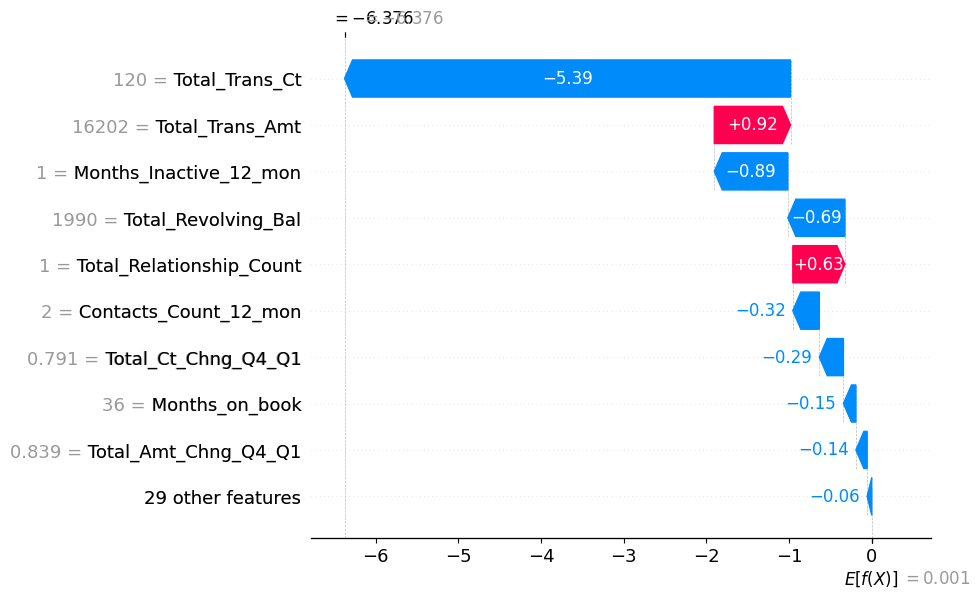

In [16]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 解釋第一筆資料
shap.plots.waterfall(shap_values[0])
